In [1]:
import cv2 as cv
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pickle

%matplotlib inline

At first we set in the variable **IMAGE_PATH** the path of the image to be used, in order to use it as a parameter of the program. Then, we read the specified image and convert it into grayscale and show it.

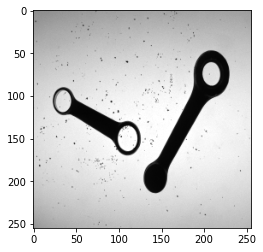

In [2]:
IMAGE_PATH = "./dataset/TESI98.BMP"

im = cv.imread(IMAGE_PATH)
im_gray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)

plt.imshow(im_gray, cmap="gray", vmin=0, vmax=255)
plt.show()

We compute and plot the histogram of the gray levels of the image, in order to analyze the distribution of the intensities and visually recognize where a threshold may be chosen in order to binarize the image.

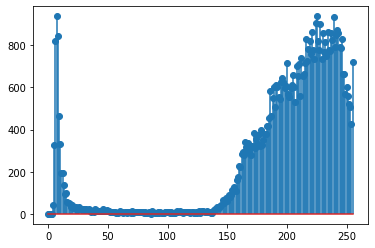

In [3]:
hist, bins = np.histogram(im_gray.flatten(), 256, [0,256])
plt.stem(hist, use_line_collection=True)
plt.show()

In order to make the binarization procedure automatic we decided to exploit Otsu's algorithm. Anyway, prior to executing it, we perform a smoothing step in order to remove iron powder so that it'll be classified as background.
We choose a Gaussian filter instead of a median one because the latter would have the drawback of amplifying and enlarging the possible contact points of the rods, leading to issues in the next phases of the processing.

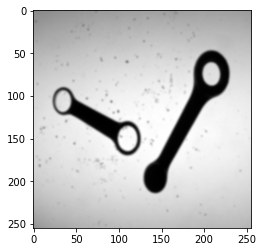

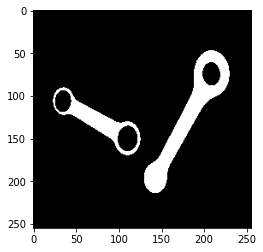

In [4]:
im_filtered = cv.GaussianBlur(im_gray, (5,5), 0)
plt.imshow(im_filtered, cmap="gray")
plt.show()
th, im_bin = cv.threshold(im_filtered, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)
plt.imshow(im_bin, cmap="gray")
plt.show()

In [5]:
def get_n_holes(blob):
    # Add padding around the rod so that the whole surrounding background is considered as a unique connected component
    blob = cv.copyMakeBorder(blob, 10, 10, 10, 10, cv.BORDER_CONSTANT, (0,0,0))

    # Perform dilation to be sure that all the circles are closed (don't care about increase of the object size)
    kernel = np.ones((5, 5), np.uint8)
    blob = cv.morphologyEx(blob, cv.MORPH_DILATE, kernel)

    # 1st label is the rod (considered as background) and 2nd label is the external actual background
    n_labels, im_labels, stats, centroids = cv.connectedComponentsWithStats(1 - blob)
    return n_labels - 2

def get_rod_type(blob):
    return "A" if get_n_holes(blob) == 1 else "B"

def process_holes(im_bin):
    # Perform opening in order to restore the image after a possible accidental deterioration of the holes implied by the separation of the rods
    # Perform opening instead of closing since the binary image is inverted (1 -> background, 0 -> foreground)
    kernel = np.ones((3, 3), np.uint8)
    im_bin = cv.morphologyEx(im_bin, cv.MORPH_OPEN, kernel)
    n_labels, im_labels, stats, centroids = cv.connectedComponentsWithStats(im_bin)

    im_out = im.copy()

    # Label 0 refers to the rods, and label 1 is the background
    for hole in range(2, n_labels):
        # Centroid Coordinates
        x = stats[hole][cv.CC_STAT_LEFT]
        y = stats[hole][cv.CC_STAT_TOP]
        # Dimensions
        width = stats[hole][cv.CC_STAT_WIDTH]
        height = stats[hole][cv.CC_STAT_HEIGHT]

        # Show the computed data on the every hole
        cv.rectangle(im_out, (x, y), (x + width, y + height), (255, 0, 0), 1)
        cv.circle(im_out, (int(x + width / 2), int(y + height / 2)), 1, (255, 0, 0), 1)
        cv.putText(im_out, str(int(x + width / 2)) + ", " + str(int(y + height / 2)), (int(x + width / 2) - 17, y - 5), cv.FONT_HERSHEY_PLAIN, 0.5, (255, 0, 0))
        cv.putText(im_out, "d = " + str(width), (int(x + width / 2) - 15, y + height + 10), cv.FONT_HERSHEY_PLAIN, 0.5, (0, 255, 0))
        
    print("HOLES")
    plt.imshow(im_out)
    plt.show()

def haralick_circularity(contour, centroid):
    dist = [np.linalg.norm(point - centroid) for point in contour]
    std = np.std(dist)
    return np.mean(dist) / std if std > 0 else float("INF")

def is_outlier(features):
    # Load the trained model and classify the blob as regular or outlier
    occ_model = pickle.load(open("occ_model.sav", "rb"))
    pred = occ_model.predict(features)
    return pred[0] == -1

def barycenter_width(cnt, b):
    # - Find the point of the object contour that is the closest to the barycentre
    # - Compute the second point (not necessarily belonging to the contour) so that it lies on the same line joining the first point and the barycentre, 
    #   keeping the distance the same
    # - Compute the euclidean distance between the two detected points, and take it as width
    cnt_points = cnt[0].reshape(-1, 2)
    euclideans = [np.linalg.norm(b - point) for point in cnt_points]
    min_point_1 = cnt_points[np.argmin(euclideans)]
    min_point_2 = np.array(2 * np.array(b) - min_point_1, dtype=int)

    return (min_point_1, min_point_2, np.linalg.norm(min_point_1 - min_point_2))

In order to recognize regions that refer to more than one rod because of contact points, we empirically determined a threshold (6000 pixels) on the area of the blob.
If that's the case, we devised a strategy based on the Convex Hull of the blob. In particular, we take advantage of the convexity defects of the hull, that are points significantly distant from the contour of the hull. Then, we compute the distance between each pair of such points, and whether this is below another empirically found threshold (19 pixels) we split the region by connecting these two points.

In order to decrease the number of points to analyze and therefore speed up the execution, we previous approximate the contour of the region through the Ramer-Douglas-Peucker algorithm.

In [6]:
n_labels, im_labels, stats, centroids = cv.connectedComponentsWithStats(im_bin)

for l in range(1, n_labels):
    if stats[l][cv.CC_STAT_AREA] > 6000:
        cnt, h = cv.findContours((im_labels == l).astype("uint8"), cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
        tmp = cv.approxPolyDP(cnt[0], 0.005 * cv.arcLength(cnt[0], False), True)
        hull = cv.convexHull(tmp, returnPoints = False)
        defects = cv.convexityDefects(tmp, hull).reshape(-1, 4)

        im_defects = cv.cvtColor(im_filtered, cv.COLOR_GRAY2RGB)
        for d in defects:
            cv.circle(im_defects, tuple(tmp[d[2]][0]), 2, [0,0,255], -1)
        
        cv.drawContours(im_defects, [tmp], -1, (0,255,0), 1)
        plt.imshow(im_defects)
        plt.show()

        distances = np.matrix([[np.linalg.norm(tmp[d1[2]][0] - tmp[d2[2]][0]) for d2 in defects] for d1 in defects])
        # 40 so that it's above the threshold
        distances[distances == 0] = 40
        further_split = True
        while further_split:
            min_dist_index = distances.argmin()
            i, j = min_dist_index // distances.shape[0], min_dist_index % distances.shape[0]

            point1_index, point2_index = defects[i][2], defects[j][2]

            if distances[i, j] > 19:
                further_split = False
            else:
                cv.line(im_bin, tuple(tmp[point1_index][0]), tuple(tmp[point2_index][0]), (0, 0, 0), 1)
                # To prevent this pair being further selected
                distances[i, j], distances[j, i] = (40,) * 2

--- ROD 1 ---
Type: A
Position: 180, 126
Orientation: 62.03
Lenght: 181
Width: 44
Width at Barycenter: 15


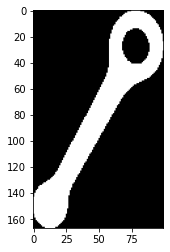

--- ROD 2 ---
Type: B
Position: 75, 129
Orientation: 149.01
Lenght: 116
Width: 36
Width at Barycenter: 17


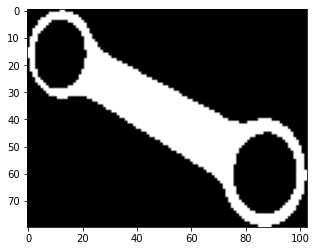

HOLES


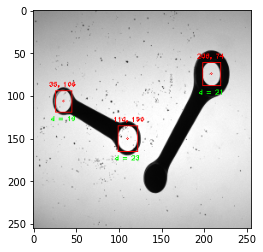

In [7]:
n_labels, im_labels, stats, centroids = cv.connectedComponentsWithStats(im_bin, connectivity = 4)

# Black image used as empty canvas to be filled only with the rods and without the distractors
# used for the later processing of the holes
im_bin_rods = np.zeros(im_bin.shape)

for l in range(1, n_labels):
    # Objects below these threshold are considered as noise (it's likely to be iron powder)
    if stats[l][cv.CC_STAT_AREA] < 100:
        continue

    # Crop a single rod
    sup = im_labels == l
    rod = sup[
        stats[l][cv.CC_STAT_TOP]:(stats[l][cv.CC_STAT_TOP] + stats[l][cv.CC_STAT_HEIGHT]),
        stats[l][cv.CC_STAT_LEFT]:(stats[l][cv.CC_STAT_LEFT] + stats[l][cv.CC_STAT_WIDTH])
    ].astype("uint8")

    cnt, h = cv.findContours(rod, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
    rect = cv.minAreaRect(cnt[0])
    _, _, angle = cv.fitEllipse(cnt[0])
    m = cv.moments(rod)
    # Compute coordinates of the centroid
    c = [m["m10"] / m["m00"], m["m01"] / m["m00"]]

    # Features for the classifier
    features = {
        "area": [stats[l][cv.CC_STAT_AREA]],
        "circularity": [haralick_circularity(cnt[0].reshape(-1, 2), c)],
        "n_holes": [get_n_holes(rod)]
    }
    if is_outlier(pd.DataFrame(features)):
        continue
    else:
        im_bin_rods = np.logical_or(im_bin_rods, im_labels == l)

    print("--- ROD " + str(l) + " ---")
    print("Type: " + get_rod_type(rod))
    print("Position: " + str(int(centroids[l][0])) + ", " + str(int(centroids[l][1])))
    print("Orientation: " + str(round((90 - angle) % 180, 2)))
    print("Lenght: " + str(int(max(rect[1]))))
    print("Width: " + str(int(min(rect[1]))))
    b_width = barycenter_width(cnt, c)
    print("Width at Barycenter: " + str(int(b_width[2])))

    plt.imshow(rod, cmap="gray")
    plt.plot()
    plt.show()

process_holes(255 - im_bin_rods.astype("uint8") * 255)